# IEOR 242 Assignment 07
Classify MDA sections of 10-K reports with scikit learn Naive Bayes and cross validation

In [1]:
import pandas as pd
import pickle
import gc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from classifier_evaluation import evaluate_classifier

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
import pymysql
from sqlalchemy import create_engine

# Connect to team database
engine = create_engine('mysql+pymysql://<user>:<password>@<host>[:<port>]/<dbname>')

In [24]:
# Standard number of features
MAX_FEATURES = 50000

## Data Loading
Read the dataframe with file contents and labels from a Pickle file.

In [25]:
with open('prepared_class.pickle', 'rb') as f:
    class_df = pickle.load(f)

print('Number of reports: %d' % len(class_df))
class_df.head()

Number of reports: 12504


,content,OIADP,AT,CEQ,SALES
0,Item7.Management's Discussion and Analysis of ...,pos,neg,neg,neg
1,The following discussion and analysis provide...,neg,pos,pos,neg
2,Item 7.\nManagements Discussion and Analysis o...,neg,pos,pos,neg
3,-----BEGIN PRIVACY-ENHANCED MESSAGE-----\nProc...,neg,neg,pos,neg
4,Item 7. Management's Discussion and Analy...,pos,neg,neg,neg


In [26]:
# Reduce data set for faster development
# class_df = class_df.sample(frac=0.5)

## Feature Building

In [27]:
# Prepare test subsets
ceq_df = class_df.loc[class_df['CEQ'] != 'NA']
print('%d out of %d reports have a CEQ label.' % (len(ceq_df), len(class_df)))
sales_df = class_df.loc[class_df['SALES'] != 'NA']
print('%d out of %d reports have a SALES label.' % (len(sales_df), len(class_df)))

12135 out of 12504 reports have a CEQ label.
10887 out of 12504 reports have a SALES label.


In [7]:
# Bag of Words
count_vec = CountVectorizer(analyzer='word', stop_words='english', max_features=MAX_FEATURES)
# Bag of Words with reduced number of features
count_vec_red_feat = CountVectorizer(analyzer='word', stop_words='english', max_features=500)
# Bag of Words with 2-grams
count_vec_2grams = CountVectorizer(analyzer='word', stop_words='english', ngram_range=(1, 2), max_features=MAX_FEATURES)
# tf-idf
tfidf_vec = TfidfVectorizer(analyzer='word', stop_words='english', max_features=MAX_FEATURES)
# tf-idf with reduced number of features
tfidf_vec_red_feat = TfidfVectorizer(analyzer='word', stop_words='english', max_features=500)
# tf-idf with 2-grams
tfidf_vec_2grams = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1, 2), max_features=MAX_FEATURES)

## Classifier Evaluation

### Baseline

In [28]:
print('%d out of %d reports have a positive CEQ label.' \
      % (len(ceq_df.loc[ceq_df['CEQ'] == 'pos']), len(ceq_df)))

6570 out of 12135 reports have a positive CEQ label.


### tf-idf

In [9]:
tfidf_matrix = tfidf_vec.fit_transform(sales_df['content'])

tfidf_eval = evaluate_classifier(MultinomialNB(fit_prior=False), tfidf_matrix, sales_df['SALES'], 5)
tfidf_eval[1]

{'Accuracy': 0.70194491115290503,
 'F1 Score': 0.79771865694981814,
 'Precision': 0.72142891656145403,
 'Recall': 0.89205158325009859}

### Bag of Words

In [10]:
count_matrix = count_vec.fit_transform(sales_df['content'])

count_eval = evaluate_classifier(MultinomialNB(fit_prior=False), count_matrix, sales_df['SALES'], 5)
count_eval[1]

{'Accuracy': 0.68496527837519361,
 'F1 Score': 0.75751955495659606,
 'Precision': 0.76834878007128626,
 'Recall': 0.74699136651718456}

### Test Multiple Labels & Classifiers

In [11]:
# Store F1 values for multiple labels
f1_score_df = pd.DataFrame()
f1_score_df.columns.name = 'Label'
f1_score_df.index.name = 'Classifier'

# Store accuracy for multiple labels
acc_score_df = pd.DataFrame()
acc_score_df.columns.name = 'Label'
acc_score_df.index.name = 'Classifier'

# List vectorizations to evaluate 
vecs = { 'BoW': count_vec, 'BoW Red. Feat.': count_vec_red_feat,
         'BoW 2-grams': count_vec_2grams,
         'tf-idf': tfidf_vec, 'tf-idf Red. Feat.': tfidf_vec_red_feat,
         'tf-idf 2-grams': tfidf_vec_2grams, }

# Prepare classifier
classifier = MultinomialNB(fit_prior=False)

In [12]:
# Calculate every vectorization and label combination
for label in ['OIADP', 'SALES', 'AT', 'CEQ']:
    for vec_name, vec in vecs.items():
        print('Classifying %s with %s.' % (label, vec_name))
        # Build matrix with reports and features
        sub_df = class_df.loc[class_df[label] != 'NA']
        matrix = vec.fit_transform(sub_df['content'])
        
        # Train and evaulate classifier
        metrics = evaluate_classifier(classifier, matrix, sub_df[label], 5)[1]
        acc_score_df.loc[vec_name, label] = metrics['Accuracy']
        f1_score_df.loc[vec_name, label] = metrics['F1 Score']

        # Free up memory
        sub_df = None
        matrix = None
        gc.collect()

Classifying OIADP with tf-idf 2-grams.
Classifying OIADP with BoW 2-grams.
Classifying OIADP with tf-idf.
Classifying OIADP with tf-idf Red. Feat..
Classifying OIADP with BoW.
Classifying OIADP with BoW Red. Feat..
Classifying SALES with tf-idf 2-grams.
Classifying SALES with BoW 2-grams.
Classifying SALES with tf-idf.
Classifying SALES with tf-idf Red. Feat..
Classifying SALES with BoW.
Classifying SALES with BoW Red. Feat..
Classifying AT with tf-idf 2-grams.
Classifying AT with BoW 2-grams.
Classifying AT with tf-idf.
Classifying AT with tf-idf Red. Feat..
Classifying AT with BoW.
Classifying AT with BoW Red. Feat..
Classifying CEQ with tf-idf 2-grams.
Classifying CEQ with BoW 2-grams.
Classifying CEQ with tf-idf.
Classifying CEQ with tf-idf Red. Feat..
Classifying CEQ with BoW.
Classifying CEQ with BoW Red. Feat..


In [13]:
# Write data back to database
# acc_score_df.to_sql('result_f1_score_matrix', engine, if_exists='replace')
# f1_score_df.to_sql('result_f1_score_matrix', engine, if_exists='replace')

In [14]:
acc_score_df

Label,OIADP,SALES,AT,CEQ
Classifier,,,,
tf-idf 2-grams,0.611061,0.647881,0.635718,0.665410
BoW 2-grams,0.484424,0.658052,0.597280,0.612317
tf-idf,0.672122,0.701932,0.664831,0.692420
tf-idf Red. Feat.,0.563775,0.606004,0.616255,0.654268
BoW,0.543194,0.685062,0.635899,0.654826
BoW Red. Feat.,0.477157,0.656637,0.580902,0.601371


In [15]:
f1_score_df

Label,OIADP,SALES,AT,CEQ
Classifier,,,,
tf-idf 2-grams,0.626727,0.734515,0.631357,0.697138
BoW 2-grams,0.082587,0.744255,0.654660,0.539519
tf-idf,0.704946,0.797697,0.658319,0.724350
tf-idf Red. Feat.,0.578000,0.676373,0.621545,0.689583
BoW,0.290620,0.757617,0.668859,0.625842
BoW Red. Feat.,0.077026,0.774013,0.649744,0.531164


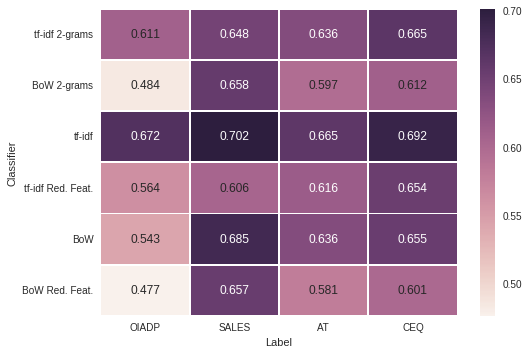

In [16]:
# Plot heat map for accuracy
sns.heatmap(acc_score_df, annot=True, fmt='.3f', linewidths=1)

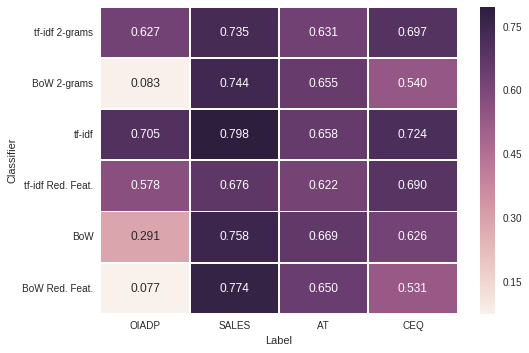

In [17]:
# Plot heat map for F1 Score
sns.heatmap(f1_score_df, annot=True, fmt='.3f', linewidths=1)

### Bag of Words - Optimize Number of Features

In [18]:
eval_df = pd.DataFrame(columns=['Max Feature'])

classifier = MultinomialNB(fit_prior=False)

for i in [100, 500, 1000, 5000, 10000, 50000, 100000]:
    print('Classifying with %d features.' % i)
    tfidf_vec = TfidfVectorizer(analyzer='word', stop_words='english', max_features=i)
    tfidf_matrix = tfidf_vec.fit_transform(sales_df['content'])
    tfidf_eval = evaluate_classifier(classifier, tfidf_matrix, sales_df['SALES'], 5)
    result = pd.DataFrame(tfidf_eval[1], index=[0])
    result['Max Feature'] = i
    eval_df = eval_df.append(result)

eval_df

Classifying with 100 features.
Classifying with 500 features.
Classifying with 1000 features.
Classifying with 5000 features.
Classifying with 10000 features.
Classifying with 50000 features.
Classifying with 100000 features.


,Accuracy,F1 Score,Max Feature,Precision,Recall
0,0.658470,0.781282,100,0.675733,0.925909
0,0.656646,0.774027,500,0.683211,0.892689
0,0.650147,0.753721,1000,0.702795,0.812604
0,0.643308,0.726304,5000,0.734393,0.718392
0,0.685076,0.757611,10000,0.768464,0.747061
0,0.791927,0.841043,50000,0.846692,0.835468
0,0.804378,0.850553,100000,0.856271,0.844910


In [19]:
# Write data back to database
eval_df.to_sql('result_max_feature_eval', engine, if_exists='replace')

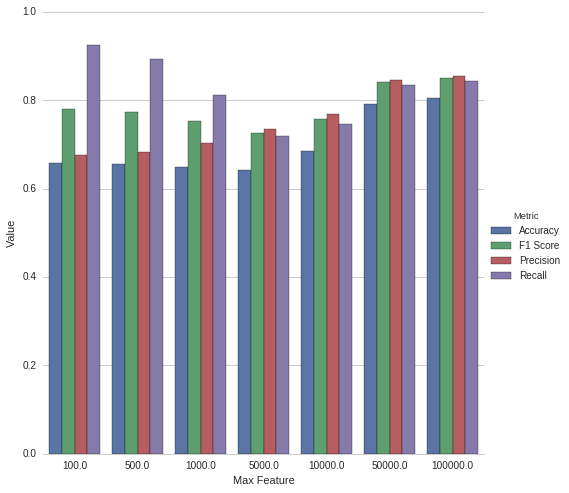

In [20]:
bar_chart_prep = pd.melt(eval_df, id_vars=['Max Feature'],
                         value_vars=['Accuracy', 'F1 Score', 'Precision', 'Recall'],
                         var_name='Metric', value_name='Value')

g = sns.factorplot(x='Max Feature', y='Value', hue='Metric', data=bar_chart_prep, size=7, kind='bar')
g.despine(left=True)
g.set_ylabels('Value')

### Bag of Words - Optimize n-grams

In [21]:
ngram_eval_df = pd.DataFrame(columns=['n'])

classifier = MultinomialNB(fit_prior=False)

for n in [1, 2, 3]:
    print('Classifying with (1,%d)-grams.' % n)
    tfidf_vec = TfidfVectorizer(analyzer='word', stop_words='english', max_features=MAX_FEATURES, ngram_range=(1,n))
    tfidf_matrix = tfidf_vec.fit_transform(sales_df['content'])
    result = pd.DataFrame(evaluate_classifier(classifier, tfidf_matrix, sales_df['SALES'], 5)[1], index=[0])
    result['n'] = n
    ngram_eval_df = ngram_eval_df.append(result)

    # Free up memory
    tfidf_vec = None
    tfidf_matrix = None
    gc.collect()

ngram_eval_df

Classifying with (1,1)-grams.
Classifying with (1,2)-grams.
Classifying with (1,3)-grams.


,Accuracy,F1 Score,Precision,Recall,n
0,0.685118,0.757678,0.768526,0.747133,1
0,0.658138,0.744338,0.733723,0.755265,2
0,0.665320,0.761254,0.718132,0.809885,3


In [22]:
# Write data back to database
ngram_eval_df.to_sql('result_ngram_eval', engine, if_exists='replace')

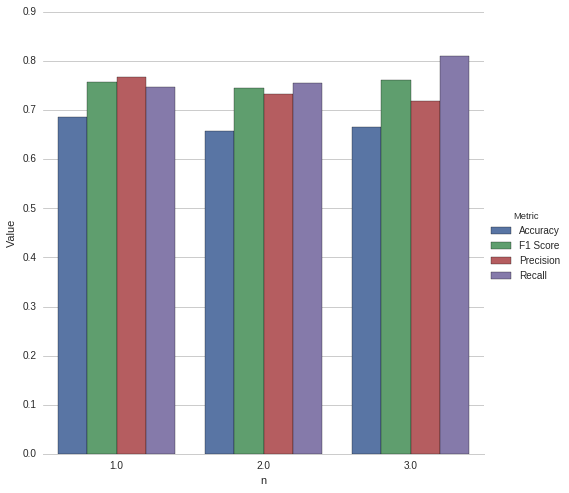

In [23]:
bar_chart_prep = pd.melt(ngram_eval_df, id_vars=['n'],
                         value_vars=['Accuracy', 'F1 Score', 'Precision', 'Recall'],
                         var_name='Metric', value_name='Value')

g = sns.factorplot(x='n', y='Value', hue='Metric', data=bar_chart_prep, size=7, kind='bar')
g.despine(left=True)
g.set_ylabels('Value')